In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, maskoceans
import tables as tb
from rpn.domains.rotated_lat_lon import RotatedLatLon
from matplotlib.gridspec import GridSpec
import numpy as np

bmap_params = {'llcrnrlat': 39.004303137858841,
               'urcrnrlat': 62.443077596938053,
               'projection': 'rotpole',
               'llcrnrlon': -86.99883217016388,
               'urcrnrlon': -40.221671371989302,
               'lon_0': -73.350000000000009,
               'o_lat_p': 37.878708451507158,
               'resolution': 'l',
               'o_lon_p': 176.70918638372871}


In [2]:
path = "/home/huziy/skynet3_rech1/hdf_store/quebec_0.1_crcm5-hcd-rl-intfl_spinup_ITFS.hdf5"
lf_node_path = "/lake_fraction"

In [3]:
proj_params = {}
with tb.open_file(path) as h:
    lons, lats = h.get_node("/longitude")[:], h.get_node("/latitude")[:]
    data = h.get_node(lf_node_path)[:]
    
    for row in h.get_node("/rotpole"):
        proj_params[row["name"].decode()] = row["value"]
        
print(proj_params)

{'lon2': 16.649999618530273, 'lat2': 0.0, 'lon1': 292.0, 'lat1': 52.0}


In [4]:
rll = RotatedLatLon(**proj_params)

{}
292.0 52.0 16.649999618530273 0.0


In [5]:
bmp = rll.get_basemap_object_for_lons_lats(lons2d=lons, lats2d=lats, resolution="l")

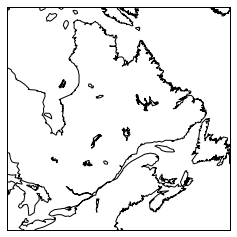

In [6]:
bmp.drawcoastlines()

In [7]:
xx, yy = bmp(lons, lats)

In [8]:
lons[lons > 180] -= 360
data = maskoceans(lons, lats, data, inlands=False)

In [9]:
def plot_ax_mean(to_plot, ax, axis_index=0, add_legend=False, xx=None, yy=None):
    
    #for all grid points
    z = np.zeros_like(to_plot)
    z[to_plot.mask] = 0
    z[~to_plot.mask] = to_plot[~to_plot.mask]
    
    xarr = z.mean(axis=axis_index) * 100
    xarr1 = to_plot.mean(axis=axis_index) * 100
    
    
    if xx is not None:
        if axis_index == 0:
            yarr = xx[:, 0]
            yarr1 = xx[:, 0]
        else:
            yarr = yy[0, :]
            yarr1 = yy[0, :]
    else:
        yarr = range(to_plot.shape[axis_index])
        yarr1 = range(to_plot.shape[axis_index])
    
    if axis_index == 0:
        xarr, yarr = yarr, xarr
        xarr1, yarr1 = yarr1, xarr1
        
    ax.plot(xarr, yarr, "k", label="All")

    #land only
    ax.plot(xarr1, yarr1, "r--", label="Land")
    
    for tl in ax.yaxis.get_ticklabels():
        tl.set_visible(axis_index == 0)

    for tl in ax.xaxis.get_ticklabels():
        tl.set_visible(axis_index == 1)

        
    if add_legend:
        ax.legend(frameon=False)
        
        
    ax.set_xlim(min(min(xarr),min(xarr1)), max(max(xarr), max(xarr1)))
    ax.set_ylim(min(min(yarr),min(yarr1)), max(max(yarr), max(yarr1)))
    

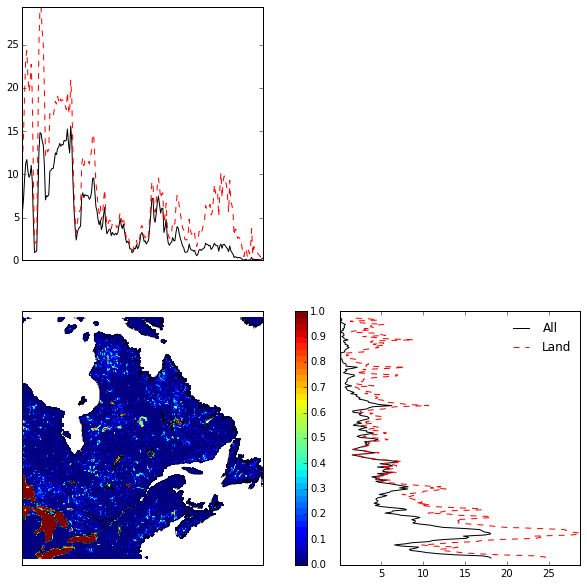

In [10]:
from matplotlib import cm

gs = GridSpec(2, 3, width_ratios=[1, 0.05, 1])

fig = plt.figure(figsize=(10, 10))
ax_field = fig.add_subplot(gs[1, 0])
ax_right = fig.add_subplot(gs[1,2], sharey=ax_field)
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_field)
cax = fig.add_subplot(gs[1, 1])

im = bmp.pcolormesh(xx, yy, data, vmin=0, vmax=1, ax=ax_field, cmap=cm.get_cmap("jet", 40))
plt.colorbar(im, cax=cax)
bmp.drawcoastlines(linewidth=0.6, ax=ax_field)

plot_ax_mean(data, ax_right, axis_index=1, add_legend=True, xx=xx, yy=yy)
plot_ax_mean(data, ax_top, axis_index=0, add_legend=False, xx=xx, yy=yy)


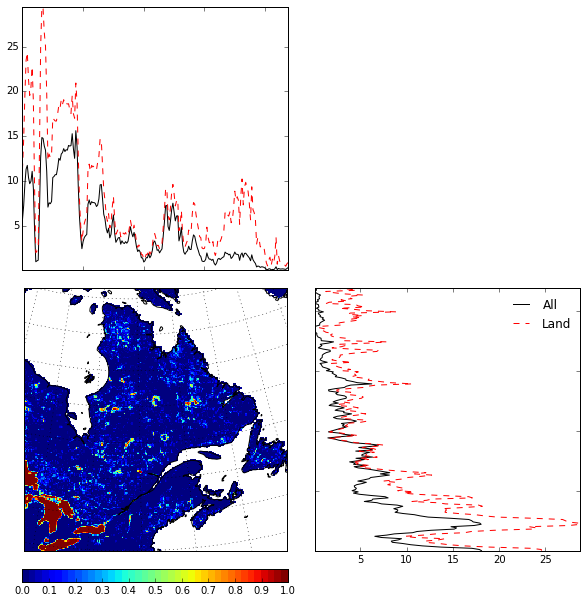

In [15]:
from cartopy import crs as ccrs
from matplotlib import cm

rpole_crs = ccrs.RotatedPole(pole_longitude=bmap_params["lon_0"] + 180, 
                             pole_latitude=bmap_params["o_lat_p"])


gs = GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 0.05], wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=(10, 10.3))
ax_field = fig.add_subplot(gs[1, 0], projection=rpole_crs)
ax_right = fig.add_subplot(gs[1,1])
ax_top = fig.add_subplot(gs[0, 0])
cax = fig.add_subplot(gs[2, 0])


plot_ax_mean(data, ax_right, axis_index=1, add_legend=True)
plot_ax_mean(data, ax_top, axis_index=0, add_legend=False)


ax_field.coastlines(resolution='50m')

ax_field.gridlines()
xll, yll = rpole_crs.transform_point(bmap_params["llcrnrlon"], bmap_params["llcrnrlat"], ccrs.Geodetic())
xur, yur = rpole_crs.transform_point(bmap_params["urcrnrlon"], bmap_params["urcrnrlat"], ccrs.Geodetic())
ax_field.set_extent([xll, xur, yll, yur], crs=rpole_crs)
tr_xy = rpole_crs.transform_points(ccrs.Geodetic(), lons, lats)

xx = tr_xy[:, :, 0]
yy = tr_xy[:, :, 1]

im = ax_field.pcolormesh(xx, yy, data, vmin=0, vmax=1, cmap=cm.get_cmap("jet", 40))
ax_field.set_extent([xx[0,0], xx[-1,-1], yy[0,0], yy[-1, -1]], crs=rpole_crs)
plt.colorbar(im, cax=cax, orientation="horizontal")
fig.savefig("lf_plot.png", bbox_inches="tight")

In [12]:
#from PIL import Image
#im = Image.open("lf_plot.png")

In [13]:
#im.show()